In [4]:
from datetime import datetime
from pathlib import Path
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import torch
from dotenv import load_dotenv
from PIL import Image
from tqdm import tqdm
from transformers import AutoConfig, AutoModelForCausalLM, AutoProcessor
load_dotenv()
from models.modeling_florence2 import Florence2ForConditionalGeneration
from models.processing_florence2 import Florence2Processor
device = torch.device("cuda")


/home/docanalysis/mambaforge/envs/thesis/lib/python3.10/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


In [5]:
PROMPT = "<AO>"
CHECKPOINT_PATH = "/home/docanalysis/florence2-training/models"
print(CHECKPOINT_PATH)
config_f = AutoConfig.from_pretrained(
    CHECKPOINT_PATH, trust_remote_code=True
)
config_f.vision_config.model_type = "davit"
config_f.vision_config.in_chans = 3
model_f = (
    AutoModelForCausalLM.from_pretrained(
        CHECKPOINT_PATH,
        trust_remote_code=True,
        config=config_f,
        torch_dtype=torch.float16,
        ignore_mismatched_sizes=True,
    )
    .to(device)
    .eval()
)
processor_f = AutoProcessor.from_pretrained(CHECKPOINT_PATH, trust_remote_code=True)

/home/docanalysis/florence2-training/models


/home/docanalysis/florence2-training/models/Wordnn_embedding.py:45: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  word_embs = torch.load(bros_embedding_path, map_location="c

use_pretrain_weight: load model from: /home/docanalysis/florence2-training/models/word_embeddings.pt


Florence2LanguageForConditionalGeneration has generative capabilities, as `prepare_inputs_for_generation` is explicitly overwritten. However, it doesn't directly inherit from `GenerationMixin`. From 👉v4.50👈 onwards, `PreTrainedModel` will NOT inherit from `GenerationMixin`, and this model will lose the ability to call `generate` and other related functions.
  - If you're using `trust_remote_code=True`, you can get rid of this warning by loading the model with an auto class. See https://huggingface.co/docs/transformers/en/model_doc/auto#auto-classes
  - If you are the owner of the model architecture code, please modify your model class such that it inherits from `GenerationMixin` (after `PreTrainedModel`, otherwise you'll get an exception).
  - If you are not the owner of the model architecture class, please contact the model code owner to update it.


In [4]:
id2label = {
    1: "Caption",
    2: "Footnote",
    3: "Formula",
    4: "ListItem",
    5: "PageFooter",
    6: "PageHeader",
    7: "Picture",
    8: "SectionHeader",
    9: "Table",
    10: "Text",
    11: "Title",
}
label2id = {v:k for k,v in id2label.items()}
prompts = ["<AO>",
            "<CAP>",
            "<FTN",
            "<FRM>",
            "<LST>",
            "<PGF>",
            "<PGH>",
            "<PIC>",
            "<SHD>",
            "<TAB>",
            "<TXT>",
            "<TTL>",]

In [5]:
from datasets import load_from_disk
dataset = load_from_disk("/home/docanalysis/florence2-training/dataset_florence2_td/train")

In [16]:
def run_example(task_prompt, example, max_new_tokens=128, input_text: str = None):
    prompt = task_prompt
    if input_text is not None:
        prompt += input_text
    image = example["image"]
    input_ids = torch.tensor(example['input_ids'])
    bbox = torch.tensor(example['subword_bboxs'])
    inputs = processor_f(text=prompt,images=image, return_tensors="pt")
    inputs = {**inputs, "grid_data":[{"input_ids": input_ids, "bbox": bbox}]}
    generated_ids = model_f.generate(
        input_ids=inputs["input_ids"].to(device),
        pixel_values = inputs["pixel_values"].half().to(device),
        grid_data = inputs['grid_data'],
        max_new_tokens=max_new_tokens,
        early_stopping=False,
        do_sample=False,
        num_beams=3,
    )
    generated_text = processor_f.batch_decode(generated_ids, skip_special_tokens=False)[0]
    parsed_answer = processor_f.post_process_generation(
        generated_text, task=task_prompt, image_size=(image.width, image.height)
    )
    return parsed_answer
def plot_bounding_boxes(image,bboxs, labels, figsize=(10, 10)):
    fig, ax = plt.subplots(figsize=figsize)
    ax.imshow(image)
    for box, label in zip(bboxs, labels):
        rect = plt.Rectangle((box[0], box[1]), box[2]-box[0], box[3]-box[1], linewidth=0.5, edgecolor='r', facecolor='g',alpha=0.3)
        #add class name
        ax.text(box[0], box[1],label, fontsize=12, color='red')
        ax.add_patch(rect)
    plt.show()

In [20]:
Prompt = "<TXT>"
i = 34
out = run_example(Prompt, dataset[i], input_text=None)
# plot_bounding_boxes(dataset[i]['image'], out[Prompt]['bboxes'], out[Prompt]['labels'])

In [21]:
out

{'<TXT>': {'bboxes': [[90.7125015258789,
    162.46249389648438,
    934.2874755859375,
    202.4375],
   [90.7125015258789,
    214.73748779296875,
    808.2124633789062,
    227.03749084472656],
   [90.7125015258789, 469.9624938964844, 934.2874755859375, 495.5874938964844],
   [90.7125015258789,
    506.86248779296875,
    934.2874755859375,
    533.5125122070312]],
  'labels': ['Text', 'Text', 'Text', 'Text']}}

In [18]:
x = processor_f.post_process_generation(out[1], task=Prompt, image_size=(dataset[0]["image"].width, dataset[0]["image"].height))

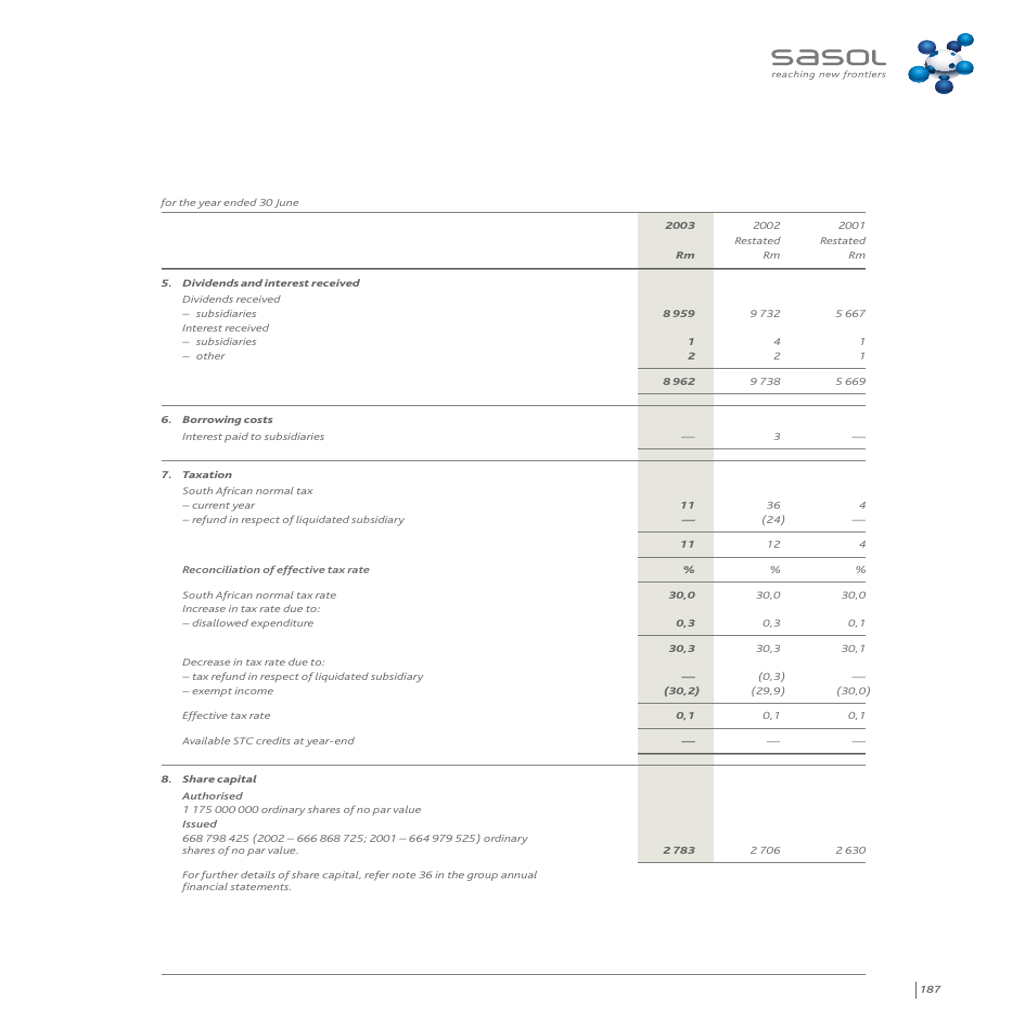

In [10]:
dataset[0]['image']

In [17]:
dataset = load_from_disk("/home/docanalysis/florence2-training/dataset_florence2_td/test")

In [ ]:
dataset[4]

dict_keys(['image', 'category_ids', 'image_id', 'boxes', 'width', 'height', 'bbox_str', 'class_strs', 'ocr_words', 'ocr_boxes', 'input_ids', 'subword_bboxs'])

# Evaluation


In [28]:
import torch
import numpy as np
import re
import json
from datasets import load_from_disk
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
from tqdm import tqdm

# ===== Configuration and Mappings =====
id2label = {
    1: "Caption",
    2: "Footnote",
    3: "Formula",
    4: "ListItem",
    5: "PageFooter",
    6: "PageHeader",
    7: "Picture",
    8: "SectionHeader",
    9: "Table",
    10: "Text",
    11: "Title",
}
label2id = {v: k for k, v in id2label.items()}

prompts = ["<AO>", "<CAP>", "<FTN", "<FRM>", "<LST>", "<PGF>",
           "<PGH>", "<PIC>", "<SHD>", "<TAB>", "<TXT>", "<TTL>"]

# Map prompts to class IDs for evaluation.
prompt_to_id = {
    "<CAP>": 1,
    "<FTN": 2,   # Verify if this prompt is correct
    "<FRM>": 3,
    "<LST>": 4,
    "<PGF>": 5,
    "<PGH>": 6,
    "<PIC>": 7,
    "<SHD>": 8,
    "<TAB>": 9,
    "<TXT>": 10,
    "<TTL>": 11,
}

# ===== Helper Functions =====
def clean_class_label(label):
    """
    Remove any location tokens (e.g. '<loc_123>') from a class label.
    """
    cleaned = re.sub(r"<loc_\d+>", "", label)
    return cleaned.strip()

def compute_iou(box1, box2):
    """
    Compute Intersection over Union (IoU) of two bounding boxes.
    Boxes are expected in [x1, y1, x2, y2] format.
    """
    x1_int = max(box1[0], box2[0])
    y1_int = max(box1[1], box2[1])
    x2_int = min(box1[2], box2[2])
    y2_int = min(box1[3], box2[3])
    
    inter_width = max(0, x2_int - x1_int)
    inter_height = max(0, y2_int - y1_int)
    intersection = inter_width * inter_height

    area1 = (box1[2] - box1[0]) * (box1[3] - box1[1])
    area2 = (box2[2] - box2[0]) * (box2[3] - box2[1])
    union = area1 + area2 - intersection
    
    if union == 0:
        return 0.0
    return intersection / union

def bbox_xyxy_to_xywh(box):
    """
    Convert a bounding box from [x1, y1, x2, y2] to [x, y, w, h] format.
    """
    return [box[0], box[1], box[2] - box[0], box[3] - box[1]]

# ===== Inference Function =====
def run_example(task_prompt, example, max_new_tokens=128, input_text: str = None):
    """
    Generate predictions for one example using the given task prompt.
    Assumes that model_f, processor_f, and device are defined in your runtime.
    """
    prompt = task_prompt
    if input_text is not None:
        prompt += input_text
    image = example["image"]
    input_ids = torch.tensor(example['input_ids'])
    bbox = torch.tensor(example['subword_bboxs'])
    inputs = processor_f(text=prompt, images=image, return_tensors="pt")
    inputs = {**inputs, "grid_data": [{"input_ids": input_ids, "bbox": bbox}]}
    generated_ids = model_f.generate(
        input_ids=inputs["input_ids"].to(device),
        pixel_values=inputs["pixel_values"].half().to(device),
        grid_data=inputs['grid_data'],
        max_new_tokens=max_new_tokens,
        early_stopping=False,
        do_sample=False,
        num_beams=3,
    )
    generated_text = processor_f.batch_decode(generated_ids, skip_special_tokens=False)[0]
    parsed_answer = processor_f.post_process_generation(
        generated_text, task=task_prompt, image_size=(image.width, image.height)
    )
    return parsed_answer

# ===== Evaluation Pipeline =====
def evaluate_layout(dataset, prompts, prompt_to_id):
    """
    Evaluate the layout analysis pipeline.
    
    For each sample:
      - Ground truth boxes and classes are processed.
      - Inference runs for every prompt are performed.
      - Only predictions matching the expected class (per prompt) are used to compute IoU and mAP.
      - Non-relevant predictions are counted for further analysis.
    
    Returns:
      - coco_gt: Ground truth in COCO format.
      - coco_dt: Detections in COCO format (only relevant predictions).
      - iou_scores: Dict of IoU scores for each class.
      - stats: Dictionary with non-relevant prediction statistics per prompt.
    """
    coco_gt = {
        "images": [],
        "annotations": [],
        "categories": []
    }
    coco_dt = []

    # Build COCO-style category list.
    for cat_id, cat_name in id2label.items():
        coco_gt["categories"].append({
            "id": cat_id,
            "name": cat_name,
        })

    # Prepare to accumulate IoU scores and prediction stats.
    iou_scores = {cat_id: [] for cat_id in id2label.keys()}
    stats = {prompt: {"total": 0, "relevant": 0, "non_relevant": 0} for prompt in prompt_to_id}
    ann_id = 1

    for sample in tqdm(dataset, desc="Evaluating samples"):
        image_id = sample["image_id"]
        width = sample["width"]
        height = sample["height"]

        coco_gt["images"].append({
            "id": image_id,
            "width": width,
            "height": height,
        })

        # Process ground truth boxes and clean class strings.
        gt_boxes = sample["boxes"]
        gt_classes = sample["class_strs"]

        for box, cls_str in zip(gt_boxes, gt_classes):
            cleaned_cls = clean_class_label(cls_str)
            cat_id = label2id.get(cleaned_cls, None)
            if cat_id is None:
                print(f"Warning: Ground truth class '{cleaned_cls}' not found in label2id mapping.")
                continue

            coco_box = bbox_xyxy_to_xywh(box)
            area = coco_box[2] * coco_box[3]
            coco_gt["annotations"].append({
                "id": ann_id,
                "image_id": image_id,
                "category_id": cat_id,
                "bbox": coco_box,
                "area": area,
                "iscrowd": 0,
            })
            ann_id += 1

        # Run inference for each prompt.
        for prompt, expected_cat_id in prompt_to_id.items():
            preds = run_example(prompt, sample, input_text=None)
            if prompt not in preds:
                continue

            pred_info = preds[prompt]
            pred_boxes = pred_info.get("bboxes", [])
            pred_labels = pred_info.get("labels", [])
            for pred_box, pred_label in zip(pred_boxes, pred_labels):
                # Update total prediction count for this prompt.
                stats[prompt]["total"] += 1

                # Clean the predicted label.
                cleaned_pred_label = clean_class_label(pred_label)
                pred_cat_id = label2id.get(cleaned_pred_label, None)

                if pred_cat_id is None:
                    print(f"Warning: Predicted class '{cleaned_pred_label}' not found in label2id mapping.")
                    stats[prompt]["non_relevant"] += 1
                    continue

                # If the predicted category does not match the expected one, count as non-relevant.
                if pred_cat_id != expected_cat_id:
                    # print(f"Warning: Predicted label '{cleaned_pred_label}' does not match expected class ID {expected_cat_id}.")
                    stats[prompt]["non_relevant"] += 1
                    continue

                # If it matches, count it as relevant.
                stats[prompt]["relevant"] += 1
                coco_box = bbox_xyxy_to_xywh(pred_box)
                score = 1.0  # Replace with an actual confidence score if available.
                coco_dt.append({
                    "image_id": image_id,
                    "category_id": pred_cat_id,
                    "bbox": coco_box,
                    "score": score,
                })

                # Compute IoU against ground truth boxes for this class.
                for gt_box, gt_cls in zip(gt_boxes, gt_classes):
                    cleaned_gt_cls = clean_class_label(gt_cls)
                    if label2id.get(cleaned_gt_cls, None) == expected_cat_id:
                        iou = compute_iou(pred_box, gt_box)
                        iou_scores[expected_cat_id].append(iou)

    return coco_gt, coco_dt, iou_scores, stats

def compute_mean_iou(iou_scores):
    """
    Compute the mean IoU per class and overall.
    """
    per_class_iou = {}
    all_scores = []
    for cat_id, scores in iou_scores.items():
        if scores:
            per_class_iou[cat_id] = np.mean(scores)
            all_scores.extend(scores)
        else:
            per_class_iou[cat_id] = 0.0
    overall_iou = np.mean(all_scores) if all_scores else 0.0
    return per_class_iou, overall_iou

def run_coco_evaluation(coco_gt_dict, coco_dt_list):
    """
    Save ground truth and predictions to temporary JSON files, then run COCO evaluation.
    """
    with open("gt_temp.json", "w") as f:
        json.dump(coco_gt_dict, f)
    dt_dict = {"annotations": coco_dt_list}
    with open("dt_temp.json", "w") as f:
        json.dump(dt_dict, f)

    coco_gt = COCO("gt_temp.json")
    coco_dt = coco_gt.loadRes("dt_temp.json")

    coco_eval = COCOeval(coco_gt, coco_dt, iouType='bbox')
    coco_eval.evaluate()
    coco_eval.accumulate()
    coco_eval.summarize()

    return coco_eval

# ===== Main Execution =====
def main():
    # Load dataset (adjust path as needed)
    dataset = load_from_disk("/home/docanalysis/florence2-training/dataset_florence2_td/test")

    # Run evaluation
    coco_gt, coco_dt, iou_scores, stats = evaluate_layout(dataset, prompts, prompt_to_id)

    # Compute and print IoU statistics.
    per_class_iou, overall_iou = compute_mean_iou(iou_scores)
    print("Per-class mean IoU (using only relevant predictions):")
    for cat_id, iou in per_class_iou.items():
        cat_name = id2label.get(cat_id, f"Class_{cat_id}")
        print(f"{cat_name}: {iou:.4f}")
    print(f"Overall mean IoU: {overall_iou:.4f}")

    # Run mAP evaluation using COCO metrics.
    print("\nRunning COCO evaluation (mAP and related metrics) using only relevant predictions:")
    coco_eval = run_coco_evaluation(coco_gt, coco_dt)
    eval_stats = coco_eval.stats
    print("COCO evaluation summary:")
    for i, stat in enumerate(eval_stats):
        print(f"Stat {i}: {stat}")

    # Report non-relevant prediction statistics per prompt.
    print("\nNon-relevant Prediction Statistics per Prompt:")
    for prompt, counts in stats.items():
        total = counts["total"]
        relevant = counts["relevant"]
        non_relevant = counts["non_relevant"]
        non_rel_rate = non_relevant / total if total > 0 else 0.0
        print(f"Prompt {prompt}: Total = {total}, Relevant = {relevant}, Non-Relevant = {non_relevant}, Non-Relevant Rate = {non_rel_rate:.2%}")


main()


Evaluating samples: 100%|██████████| 4992/4992 [2:01:27<00:00,  1.46s/it]  


Per-class mean IoU (using only relevant predictions):
Caption: 0.2720
Footnote: 0.0537
Formula: 0.0226
ListItem: 0.0351
PageFooter: 0.1286
PageHeader: 0.4973
Picture: 0.1639
SectionHeader: 0.1448
Table: 0.1933
Text: 0.0854
Title: 0.3862
Overall mean IoU: 0.1216

Running COCO evaluation (mAP and related metrics) using only relevant predictions:
loading annotations into memory...
Done (t=0.22s)
creating index...
index created!
Loading and preparing results...


AssertionError: results in not an array of objects

In [6]:
all_img_ids = cocoGT.getImgIds()
import random
def xyxy_to_xywh(box):
    return [box[0], box[1], box[2]-box[0], box[3]-box[1]], (box[2]-box[0])*(box[3]-box[1])
def create_preds(boxes, labels, img_id):
    predictions = []
    for box, label in zip(boxes, labels):
        if label == 'Table':
            box, area = xyxy_to_xywh(box)
            predictions.append({'bbox':box, 
                                'score':random.uniform(0.8,0.99), 
                                'image_id':img_id, 
                                'category_id':4, 
                                'area':area})
    return predictions
predictions = []
from tqdm import tqdm
for img_id in tqdm(all_img_ids):
    image_instance = cocoGT.loadImgs([img_id])
    file_name = image_instance[0]['file_name']
    ocr_file_name = file_name[:-3] + 'json'
    img_path = os.path.join(IMAGES_ROOT, file_name)
    ocr_file_path = os.path.join(OCR_ROOT, ocr_file_name)
    ocr = json.load(open(ocr_file_path))
    image = Image.open(img_path).convert("RGB")
    texts = [t['text'] for t in ocr]
    bboxs = [t['bbox'] for t in ocr]
    out = run_example(PROMPT, image, texts, bboxs )[PROMPT]
    boxes = out['bboxes']
    classes = out['labels']
    predictions.extend(create_preds(boxes,classes, img_id))

100%|██████████| 235/235 [01:34<00:00,  2.49it/s]


In [3]:
def plot_bbox(image, data1, data2, save_path):
    # Create a figure with two subplots side by side
    fig, axes = plt.subplots(1, 2, figsize=(20, 20))

    # Display the image with the first set of bounding boxes
    ax1 = axes[0]
    ax1.imshow(image)
    for bbox, label in zip(data1["bboxes"], data1["labels"]):
        x1, y1, x2, y2 = bbox
        rect = patches.Rectangle(
            (x1, y1), x2 - x1, y2 - y1, linewidth=1, edgecolor="r", facecolor="none"
        )
        ax1.add_patch(rect)
        ax1.text(
            x1,
            y1,
            label,
            color="white",
            fontsize=8,
            bbox=dict(facecolor="red", alpha=0.5),
        )
    ax1.axis("off")
    ax1.set_title("Fintuned")

    # Display the image with the second set of bounding boxes
    ax2 = axes[1]
    ax2.imshow(image)
    for bbox, label in zip(data2["bboxes"], data2["labels"]):
        x1, y1, x2, y2 = bbox
        rect = patches.Rectangle(
            (x1, y1), x2 - x1, y2 - y1, linewidth=1, edgecolor="b", facecolor="none"
        )
        ax2.add_patch(rect)
        ax2.text(
            x1,
            y1,
            label,
            color="white",
            fontsize=8,
            bbox=dict(facecolor="blue", alpha=0.5),
        )
    ax2.axis("off")
    ax2.set_title("Original")

    # Show the plot
    plt.tight_layout()
    plt.savefig(save_path, 
            bbox_inches ="tight", 
            pad_inches = 1, 
            transparent = True, 
            facecolor ="g", 
            edgecolor ='w', 
            orientation ='landscape') 
    plt.close()

### Previous Model

In [3]:
PROMPT = "<OD>"
CHECKPOINT_PATH = "thewalnutaisg/florence2-original-doclanynet-20k"
print(CHECKPOINT_PATH)
config_f = AutoConfig.from_pretrained(
    'microsoft/Florence-2-base', trust_remote_code=True
)
config_f.vision_config.model_type = "davit"
model_f = (
    AutoModelForCausalLM.from_pretrained(
        CHECKPOINT_PATH,
        trust_remote_code=True,
        config=config_f,
        torch_dtype=torch.float16,
    )
    .to(device)
    .eval()
)
processor_f = AutoProcessor.from_pretrained(CHECKPOINT_PATH, trust_remote_code=True)

thewalnutaisg/florence2-original-doclanynet-20k


A new version of the following files was downloaded from https://huggingface.co/thewalnutaisg/florence2-base-doclaynet-fintabnet-125000:
- processing_florence2.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


In [10]:
PROMPT = "<OD>"
CHECKPOINT_PATH = "thewalnutaisg/florence2-base-doclaynet-fintabnet-125000"
model_revision = "refs/pr/2"
print(CHECKPOINT_PATH)
config_o = AutoConfig.from_pretrained(
    'microsoft/Florence-2-base', trust_remote_code=True
)
config_o.vision_config.model_type = "davit"
model_o = (
    AutoModelForCausalLM.from_pretrained(
        CHECKPOINT_PATH,
        trust_remote_code=True,
        config=config_o,
        torch_dtype=torch.float16,
        revision="refs/pr/4",
    )
    .to(device)
    .eval()
)
processor = AutoProcessor.from_pretrained(CHECKPOINT_PATH, trust_remote_code=True)

thewalnutaisg/florence2-base-doclaynet-fintabnet-125000


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [13]:
device = torch.device("cuda")
PROMPT = "<OD>"
def run_example(task_prompt, image, model,processor, max_new_tokens=256, input_text: str = None):
    prompt = task_prompt
    if input_text is not None:
        prompt += input_text
    inputs = processor(text=prompt, images=image, return_tensors="pt")
    generated_ids = model.generate(
        input_ids=inputs["input_ids"].to(device),
        pixel_values=inputs["pixel_values"].half().to(device),
        max_new_tokens=max_new_tokens,
        early_stopping=False,
        do_sample=False,
        num_beams=3,
    )
    generated_text = processor.batch_decode(generated_ids, skip_special_tokens=False)[0]
    parsed_answer = processor.post_process_generation(
        generated_text, task=task_prompt, image_size=(image.width, image.height)
    )
    return parsed_answer, generated_text, inputs


In [14]:
from PIL import Image
image = Image.open("/home/saeed/florence2-training/0bbc1536bb50b9b010bb0d7470ead029258b7da4e7230c1c30e6e9e3f0b1a588.png").convert("RGB")
out, text , inputs= run_example(PROMPT, image, model_f,  processor_f, max_new_tokens=256)

In [15]:
inputs

{'input_ids': tensor([[    0,   574, 22486,     5,  8720,    19,  4120,   766,    11,     5,
          2274,     4,     2]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]), 'pixel_values': tensor([[[[2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
          [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
          [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
          ...,
          [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
          [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
          [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489]],

         [[2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286],
          [2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286],
          [2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286],
          ...,
          [2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286],
          [2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286],
          [2.4286, 2.4286, 2.42

##  Run Eval

In [12]:
all_img_ids = cocoGT.getImgIds()
import random
def xyxy_to_xywh(box):
    return [box[0], box[1], box[2]-box[0], box[3]-box[1]], (box[2]-box[0])*(box[3]-box[1])
def create_preds(boxes, labels, img_id):
    predictions = []
    for box, label in zip(boxes, labels):
        if label == 'Table':
            box, area = xyxy_to_xywh(box)
            predictions.append({'bbox':box, 
                                'score':random.uniform(0.8,0.99), 
                                'image_id':img_id, 
                                'category_id':4, 
                                'area':area})
    return predictions
predictions = []
from tqdm import tqdm
for img_id in tqdm(all_img_ids):
    image_instance = cocoGT.loadImgs([img_id])
    file_name = image_instance[0]['file_name']
    img_path = os.path.join(IMAGES_ROOT, file_name)
    image = Image.open(img_path).convert("RGB")
    out = run_example(PROMPT, image, model_o, processor_o )[PROMPT]
    boxes = out['bboxes']
    classes = out['labels']
    predictions.extend(create_preds(boxes,classes, img_id))

100%|██████████| 235/235 [00:43<00:00,  5.44it/s]


In [13]:
from pycocotools.cocoeval import COCOeval
imgIds=sorted(cocoGT.getImgIds())
cocoPRED = cocoGT.loadRes(predictions)
cocoEval = COCOeval(cocoGT,cocoPRED,'bbox')
cocoEval.params.imgIds  = imgIds
cocoEval.params.catIds = [4]
cocoEval.evaluate()
cocoEval.accumulate()
cocoEval.summarize()

Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.11s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.646
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.815
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.730
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.646
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.210
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.749
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.749
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=

## Save Plots

In [21]:
all_img_ids = cocoGT.getImgIds()
import random
save_path = './viz'
from tqdm import tqdm
for img_id in tqdm(all_img_ids):
    image_instance = cocoGT.loadImgs([img_id])
    file_name = image_instance[0]['file_name']
    img_path = os.path.join(IMAGES_ROOT, file_name)
    image = Image.open(img_path).convert("RGB")
    original_pred = run_example(PROMPT, image, model_o, processor_o)[PROMPT]
    new_preds = run_example(PROMPT, image, model_f, processor_f)[PROMPT]
    path_to_save = os.path.join(save_path, file_name)
    plot_bbox(image, new_preds, original_pred, path_to_save)
    
    

100%|██████████| 235/235 [03:34<00:00,  1.10it/s]


In [11]:
from pycocotools.cocoeval import COCOeval
imgIds=sorted(cocoGT.getImgIds())
cocoPRED = cocoGT.loadRes(predictions)
cocoEval = COCOeval(cocoGT,cocoPRED,'bbox')
cocoEval.params.imgIds  = imgIds
cocoEval.params.catIds = [4]
cocoEval.evaluate()
cocoEval.accumulate()
cocoEval.summarize()

Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.10s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.680
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.839
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.759
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.680
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.216
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.786
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.786
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=

</s><s>Table<loc_124><loc_127><loc_833><loc_251><loc_124><loc_293><loc_833><loc_390><loc_124><loc_433><loc_833><loc_543><loc_124><loc_589><loc_833><loc_771><loc_124><loc_813><loc_834><loc_924></s>


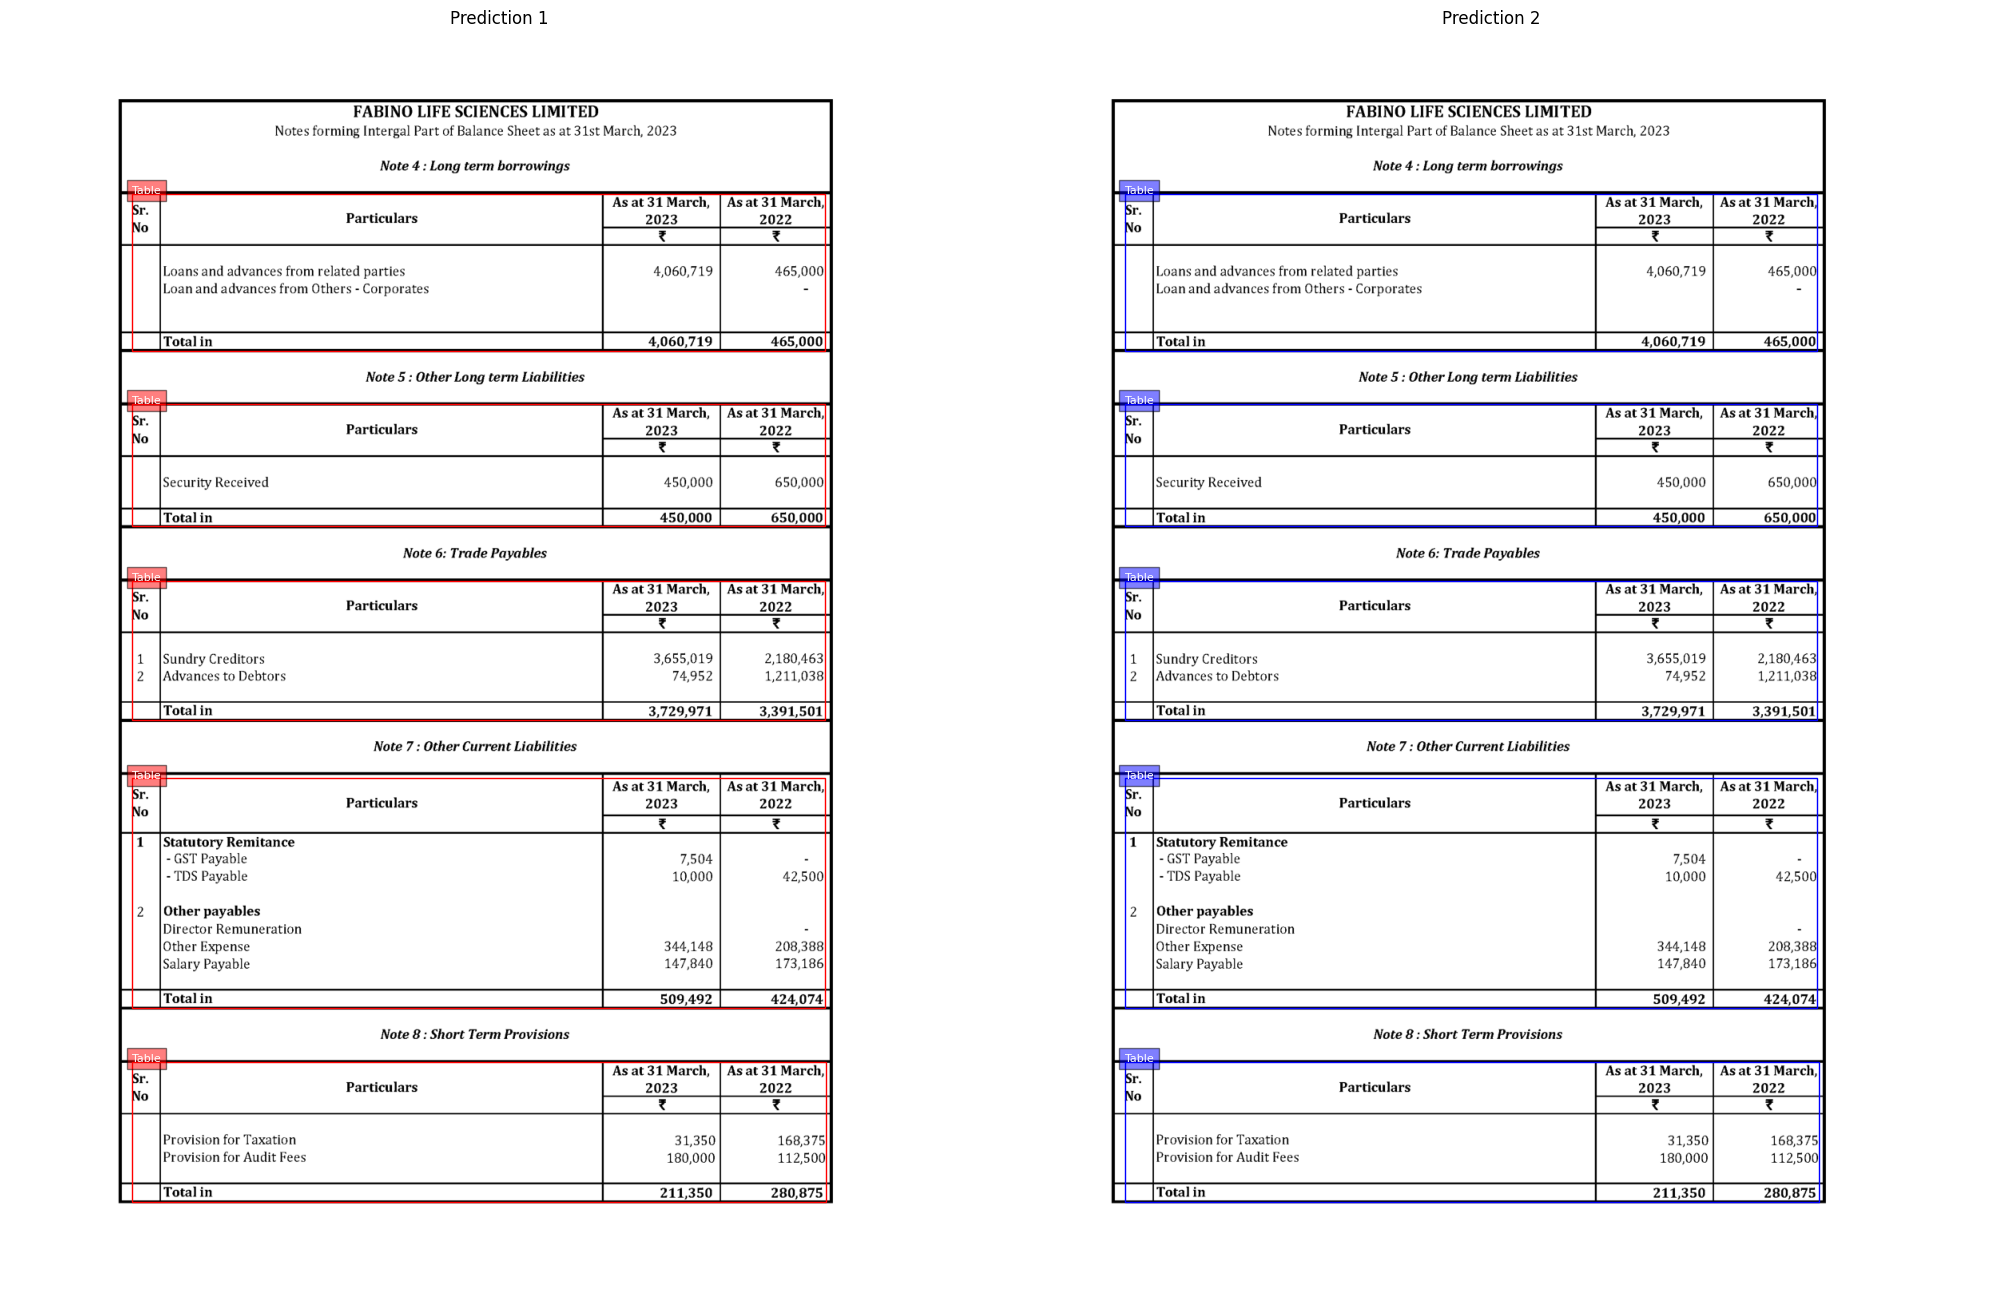

In [48]:
import random
import json
from PIL import Image
all_images = os.listdir(IMAGES_ROOT)
# chosen_image = random.choice(all_images)
image_name = chosen_image[:-3]
image_path = os.path.join(IMAGES_ROOT, chosen_image)
image = Image.open(image_path)
output = run_example(PROMPT, image)
plot_bbox(image, output[PROMPT], output[PROMPT])

In [40]:
image_name

'1f64963d-44b1-40e9-aaa1-5c4bbcfd6e85_page_61.'

## Fintabnet Testing

In [4]:
ROOT = '/media/saeed/cb770179-4e9f-49f3-b105-5be4357ac72e/Filtered-Fintabnet-COCO'
coco_path = os.path.join(ROOT, 'annotations', 'instances_test.json')
fintabnet_coco = COCO(coco_path)
import json
fintab_test_json = json.load(open(coco_path))

loading annotations into memory...
Done (t=1.28s)
creating index...
index created!


In [1]:
new_coco = {'images':[], 'annotations':[], 'categories':[]}
import json
old = json.load(open('200_sample_fintabnet.json'))
new_coco['annotations'] = old['annotations']
new_coco['categories'] = old['categories']
for img in old['images']:
    new_coco['images'].append(img[0])
json.dump(new_coco, open('200_corrected.json', 'w'))

In [9]:
from tqdm import tqdm
import random
img_ids = fintabnet_coco.getImgIds()
new_annotations = {'images':[], 'annotations':[], 'categories':fintab_test_json['categories']}
for i in  range(200):
    id_ = random.choice(img_ids)
    annot_ids = fintabnet_coco.getAnnIds([id_])
    img = fintabnet_coco.loadImgs([id_])
    annots = fintabnet_coco.loadAnns(annot_ids)
    new_annotations['annotations'].extend(annots)
    new_annotations['images'].append(img)



In [13]:
json.dump(new_annotations, open('200_sample_fintabnet.json', 'w'))

## Table Extract Eval

In [1]:
from datetime import datetime
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import torch
from datasets import Dataset, load_dataset
from dotenv import load_dotenv
from fitz_utils import ProcessedDoc
from PIL import Image, ImageDraw, ImageFont
from tqdm import tqdm
from transformers import AutoConfig, AutoModelForCausalLM, AutoProcessor
load_dotenv()
device = torch.device("cuda")
PROMPT = "<OD>"
CHECKPOINT_PATH = "/home/saeed/Walnut/florence2-training/original_florence"
model_revision = "main"
base_output_folder = Path("./outputs")
print(CHECKPOINT_PATH)

ID2LABEL = {1: "table", 2: "column", 3: "row", 4: "head", 5: "head_row", 6: "span_cell"}
LABEL2ID = {v:k for k,v in ID2LABEL.items()}

config = AutoConfig.from_pretrained(
    CHECKPOINT_PATH, trust_remote_code=True, revision=model_revision,
)
config.vision_config.model_type = "davit"
model = (
    AutoModelForCausalLM.from_pretrained(
        CHECKPOINT_PATH,
        trust_remote_code=True,
        config=config,
        revision=model_revision,
        torch_dtype=torch.float16,

    )
    .to(device)
    .eval()
)
processor = AutoProcessor.from_pretrained(CHECKPOINT_PATH, trust_remote_code=True)

/home/saeed/anaconda3/envs/vgt/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


/home/saeed/Walnut/florence2-training/original_florence


In [2]:
def plot_bbox_image(image: Image.Image, data: dict[str, list]) -> Image.Image:
    def draw_boxes(
        draw: ImageDraw,
        box: list[float | int],
        label: str,
        color: tuple,
        is_xywh: bool = False,
    ) -> None:
        if is_xywh:
            # Convert xywh to xyxy
            x1, y1, w, h = box
            x2, y2 = x1 + w, y1 + h
        else:
            x1, y1, x2, y2 = box
        draw.rectangle([x1, y1, x2, y2], outline=color, width=2)

        text_bbox = draw.textbbox((0, 0), label)
        font_size = 15
        label_h = text_bbox[3] - text_bbox[1]
        label_y = y1 - label_h * font_size / 10 - 10
        label_x = x1
        font = ImageFont.load_default(font_size)
        draw.text((label_x, label_y), label, fill="black", font=font)

    def create_color_map(num_classes: int) -> np.ndarray:
        return plt.get_cmap("tab10")(np.linspace(0, 1, num_classes))

    # Create a copy of the image to draw on
    color_map = create_color_map(len(ID2LABEL))
    draw_image = image.copy()
    draw = ImageDraw.Draw(draw_image)

    # Plot each bounding box
    for box, label in zip(data["bboxes"], data["labels"]):
        category_id = LABEL2ID[label]
        color = tuple(int(x * 255) for x in color_map[category_id - 1][:3])
        draw_boxes(draw, box, label, color)

    return draw_image

In [3]:
def run_example(task_prompt, image, max_new_tokens=512, input_text: str = None):
    prompt = task_prompt
    if input_text is not None:
        prompt += input_text
    inputs = processor(text=prompt, images=image, return_tensors="pt")
    generated_ids = model.generate(
        input_ids=inputs["input_ids"].to(device),
        pixel_values=inputs["pixel_values"].half().to(device),
        max_new_tokens=max_new_tokens,
        early_stopping=False,
        do_sample=False,
        num_beams=3,
    )
    generated_text = processor.batch_decode(generated_ids, skip_special_tokens=False)[0]
    parsed_answer = processor.post_process_generation(
        generated_text, task=task_prompt, image_size=(image.width, image.height)
    )
    return parsed_answer

## Evaluation of Florece table extraction

In [1]:
import os
data_root = '/home/saeed/Walnut/VGT/Filtered-Fintabnet-COCO'
image_paths = os.path.join(data_root, 'test2017')
annotations_path = '/home/saeed/Walnut/florence2-training/sampled_test_300_img_fintabnet_annot.json'
from pycocotools.coco import COCO 
cocogt = COCO(annotations_path)
ID2LABEL = {0: "table", 1: "column", 2: "row", 3: "head", 4: "head_row", 5: "span_cell"}
LABEL2ID = {v:k for k,v in ID2LABEL.items()}

loading annotations into memory...


FileNotFoundError: [Errno 2] No such file or directory: '/home/saeed/Walnut/florence2-training/sampled_test_300_img_fintabnet_annot.json'

In [5]:
def xyxy_to_xywh(box):
    return [box[0], box[1], 
            box[2]-box[0],
            box[3]-box[1]]
def valid_box(box):
    if (box[2]-box[0]) > 0 and (box[3]-box[1]) > 0:
        return True
    return False
def process_row(box, table_box):
    return [table_box[0], box[1], table_box[2], box[3]]
def process_col(box, table_box):
    return [box[0], table_box[1], box[2], table_box[3]]

def create_preds(img_preds , img_id):
    preds = []
    table_idx = img_preds['labels'].index('table')
    table_bbox = img_preds['bboxes'][table_idx]
    for label, bbox in zip(img_preds['labels'], img_preds['bboxes']):
        if not valid_box(bbox):
            print(f"The bbox {bbox} is not a valid box")
            continue
        if label not in LABEL2ID:
            print(f"The label {label} is not in the map")
            continue
        if label == 'row' or label == 'head' or label == 'head_row':
            bbox = process_row(bbox, table_bbox)
        if label == 'column':
            bbox = process_col(bbox, table_bbox) 
        lab = LABEL2ID.get(label)
        converted_bbox = xyxy_to_xywh(bbox)
        preds.append({
            'image_id': img_id,
            'category_id': lab,
            'score': 1, 
            'bbox': converted_bbox
        })
    return preds

all_img_ids = cocogt.getImgIds()
predictions = []
from tqdm import tqdm
for img_id in tqdm(all_img_ids):
    image_instance = cocogt.loadImgs([img_id])
    file_name = image_instance[0]['file_name']
    img_path = os.path.join(image_paths, file_name)
    image = Image.open(img_path).convert("RGB")
    original_pred = run_example(PROMPT, image, )[PROMPT]
    predictions.extend(create_preds(original_pred, img_id))

  3%|▎         | 9/297 [00:04<01:54,  2.51it/s]

The bbox [597.0615234375, 28.756999969482422, 675.5385131835938, 18.029001235961914] is not a valid box


  7%|▋         | 21/297 [00:11<03:19,  1.38it/s]

The bbox [354.0074768066406, 27.341999053955078, 354.0074768066406, 458.9339904785156] is not a valid box
The bbox [28.29749870300293, 556.5419921875, 354.0074768066406, 556.5419921875] is not a valid box
The bbox [354.0074768066406, 124.94999694824219, 354.0074768066406, 140.8260040283203] is not a valid box
The bbox [354.0074768066406, 157.2899932861328, 354.0074768066406, 171.99000549316406] is not a valid box
The bbox [354.0074768066406, 184.33799743652344, 354.0074768066406, 197.86199951171875] is not a valid box
The bbox [354.0074768066406, 210.2100067138672, 354.0074768066406, 223.14599609375] is not a valid box
The bbox [354.0074768066406, 234.3179931640625, 354.0074768066406, 247.25399780273438] is not a valid box
The bbox [354.0074768066406, 260.7779846191406, 354.0074768066406, 276.0660095214844] is not a valid box


 13%|█▎        | 38/297 [00:17<01:37,  2.64it/s]

The bbox [521.031005859375, 28.761999130249023, 569.79296875, 17.081998825073242] is not a valid box
The bbox [27.993000030517578, 46.573997497558594, 569.79296875, 46.573997497558594] is not a valid box


 13%|█▎        | 40/297 [00:18<01:54,  2.24it/s]

The bbox [498.5885009765625, 28.597501754760742, 558.0775146484375, 15.484500885009766] is not a valid box


 18%|█▊        | 53/297 [00:23<01:43,  2.36it/s]

The bbox [404.1780090332031, 29.27750015258789, 460.2660217285156, 8.697500228881836] is not a valid box
The bbox [460.2660217285156, 29.27750015258789, 460.2660217285156, 172.3574981689453] is not a valid box


 21%|██        | 62/297 [00:27<01:35,  2.45it/s]

The bbox [28.645498275756836, 27.834501266479492, 24.23849868774414, 42.87050247192383] is not a valid box


 25%|██▍       | 73/297 [00:34<03:42,  1.00it/s]

The bbox [671.0134887695312, 28.173500061035156, 671.0134887695312, 801.052490234375] is not a valid box


 26%|██▌       | 77/297 [00:35<01:51,  1.98it/s]

The bbox [609.1495361328125, 28.216999053955078, 671.0134887695312, 14.595000267028809] is not a valid box


 28%|██▊       | 82/297 [00:37<01:32,  2.32it/s]

The bbox [604.4625244140625, 28.100000381469727, 644.2875366210938, 1.899999976158142] is not a valid box
The bbox [644.2875366210938, 28.100000381469727, 644.2875366210938, 51.900001525878906] is not a valid box


 33%|███▎      | 97/297 [00:43<01:19,  2.53it/s]

The bbox [644.0850219726562, 27.63450050354004, 702.8050537109375, 1.9665000438690186] is not a valid box
The bbox [702.8050537109375, 27.63450050354004, 702.8050537109375, 140.2425079345703] is not a valid box


 34%|███▍      | 101/297 [00:45<01:39,  1.98it/s]

The bbox [639.2055053710938, 29.02499771118164, 685.8104858398438, 11.480998992919922] is not a valid box
The bbox [685.8104858398438, 29.02499771118164, 685.8104858398438, 183.8249969482422] is not a valid box


 39%|███▊      | 115/297 [00:52<01:10,  2.57it/s]

The bbox [28.937999725341797, 28.11750030517578, 21.941999435424805, 314.4674987792969] is not a valid box
The bbox [28.937999725341797, 314.4674987792969, 605.1539916992188, 314.4674987792969] is not a valid box


 40%|███▉      | 118/297 [00:53<01:12,  2.47it/s]

The bbox [518.657958984375, 29.599998474121094, 605.1539916992188, 21.279998779296875] is not a valid box


 41%|████      | 122/297 [00:55<01:03,  2.77it/s]

The bbox [28.222999572753906, 28.406999588012695, 24.843000411987305, 44.21699905395508] is not a valid box
The bbox [306.7349853515625, 57.98699951171875, 28.222999572753906, 57.98699951171875] is not a valid box


 44%|████▍     | 131/297 [00:59<01:17,  2.14it/s]

The bbox [28.937999725341797, 69.50150299072266, 74.72999572753906, 69.50150299072266] is not a valid box


 46%|████▌     | 137/297 [01:02<01:35,  1.67it/s]

The bbox [28.937999725341797, 30.003000259399414, 21.941999435424805, 30.003000259399414] is not a valid box
The bbox [605.1539916992188, 53.01900100708008, 28.937999725341797, 53.01900100708008] is not a valid box
The bbox [605.1539916992188, 70.281005859375, 28.937999725341797, 70.281005859375] is not a valid box
The bbox [605.1539916992188, 85.89900207519531, 28.937999725341797, 85.89900207519531] is not a valid box
The bbox [605.1539916992188, 101.51700592041016, 28.937999725341797, 101.51700592041016] is not a valid box
The bbox [605.1539916992188, 117.13500213623047, 28.937999725341797, 117.13500213623047] is not a valid box
The bbox [605.1539916992188, 131.93099975585938, 28.937999725341797, 131.93099975585938] is not a valid box
The bbox [605.1539916992188, 146.7270050048828, 28.937999725341797, 146.7270050048828] is not a valid box
The bbox [605.1539916992188, 161.52301025390625, 28.937999725341797, 161.52301025390625] is not a valid box
The bbox [605.1539916992188, 177.141006

 47%|████▋     | 140/297 [01:03<01:21,  1.93it/s]

The bbox [306.6524963378906, 29.509498596191406, 354.0074768066406, 19.00349998474121] is not a valid box


 49%|████▉     | 145/297 [01:06<01:16,  1.98it/s]

The bbox [719.4915161132812, 41.8125, 719.4915161132812, 527.5065307617188] is not a valid box


 51%|█████     | 151/297 [01:08<01:06,  2.20it/s]

The bbox [544.9010009765625, 15.619500160217285, 544.9010009765625, 27.90450096130371] is not a valid box
The bbox [544.9010009765625, 27.90450096130371, 614.6690063476562, 27.90450096130371] is not a valid box
The bbox [614.6690063476562, 65.8125, 614.6690063476562, 124.07850646972656] is not a valid box
The bbox [614.6690063476562, 165.84750366210938, 614.6690063476562, 232.8885040283203] is not a valid box
The bbox [614.6690063476562, 282.7304992675781, 614.6690063476562, 320.6385192871094] is not a valid box
The bbox [28.74700164794922, 15.619500160217285, 22.28700065612793, 82.30950164794922] is not a valid box


 53%|█████▎    | 157/297 [01:12<01:17,  1.82it/s]

The bbox [549.4400024414062, 28.80249786376953, 608.9599609375, 14.7524995803833] is not a valid box


 53%|█████▎    | 158/297 [01:12<01:10,  1.98it/s]

The bbox [552.0, 28.426000595092773, 608.9599609375, 8.906000137329102] is not a valid box


 55%|█████▍    | 162/297 [01:15<01:13,  1.85it/s]

The bbox [521.3674926757812, 28.3075008392334, 570.0485229492188, 24.957500457763672] is not a valid box


 57%|█████▋    | 170/297 [01:17<00:49,  2.54it/s]

The bbox [530.7000122070312, 29.127500534057617, 567.9000244140625, 18.75749969482422] is not a valid box


 61%|██████    | 181/297 [01:23<00:55,  2.10it/s]

The bbox [532.9765014648438, 29.139999389648438, 590.91552734375, 9.052000045776367] is not a valid box


 65%|██████▍   | 193/297 [01:29<00:47,  2.18it/s]

The bbox [532.4600219726562, 29.200498580932617, 600.7160034179688, 19.00349998474121] is not a valid box


 65%|██████▌   | 194/297 [01:30<00:49,  2.06it/s]

The bbox [553.6109619140625, 29.57400131225586, 622.281005859375, 29.57400131225586] is not a valid box


 72%|███████▏  | 213/297 [01:38<00:33,  2.50it/s]

The bbox [509.24249267578125, 29.197500228881836, 553.1174926757812, 6.06850004196167] is not a valid box


 74%|███████▎  | 219/297 [01:40<00:26,  2.94it/s]

The bbox [471.79998779296875, 28.11750030517578, 529.47998046875, 25.702499389648438] is not a valid box


 75%|███████▍  | 222/297 [01:41<00:27,  2.70it/s]

The bbox [509.11798095703125, 28.510499954223633, 605.1539916992188, 9.088500022888184] is not a valid box


 77%|███████▋  | 228/297 [01:44<00:35,  1.93it/s]

The bbox [422.9010009765625, 29.830001831054688, 422.9010009765625, 594.4020385742188] is not a valid box


 82%|████████▏ | 244/297 [01:52<00:20,  2.63it/s]

The bbox [28.569000244140625, 126.0050048828125, 610.863037109375, 126.0050048828125] is not a valid box


 84%|████████▍ | 249/297 [01:54<00:21,  2.23it/s]

The bbox [614.81201171875, 29.417499542236328, 681.0280151367188, 15.067500114440918] is not a valid box


 84%|████████▍ | 250/297 [01:54<00:20,  2.33it/s]

The bbox [289.47601318359375, 28.30500030517578, 312.8680114746094, 4.328999996185303] is not a valid box


 86%|████████▌ | 254/297 [01:56<00:20,  2.08it/s]

The bbox [638.4454956054688, 30.845998764038086, 689.6365356445312, 2.0139999389648438] is not a valid box
The bbox [689.6365356445312, 30.845998764038086, 689.6365356445312, 55.4379997253418] is not a valid box


 88%|████████▊ | 260/297 [01:58<00:13,  2.69it/s]

The bbox [65.22750091552734, 221.2484893798828, 553.1174926757812, 221.2484893798828] is not a valid box
The bbox [553.1174926757812, 28.20949935913086, 553.1174926757812, 52.49749755859375] is not a valid box
The bbox [456.0074768066406, 52.7504997253418, 456.0074768066406, 66.15950012207031] is not a valid box


 90%|████████▉ | 266/297 [02:01<00:13,  2.29it/s]

The bbox [617.2150268554688, 29.48750114440918, 698.2449951171875, 24.4325008392334] is not a valid box


 94%|█████████▎| 278/297 [02:06<00:08,  2.12it/s]

The bbox [654.3610229492188, 28.262500762939453, 702.071044921875, 21.479501724243164] is not a valid box


 94%|█████████▍| 279/297 [02:06<00:08,  2.08it/s]

The bbox [578.58349609375, 28.09000015258789, 617.5234985351562, 3.2860000133514404] is not a valid box
The bbox [617.5234985351562, 28.09000015258789, 617.5234985351562, 28.09000015258789] is not a valid box


 98%|█████████▊| 290/297 [02:11<00:02,  2.57it/s]

The bbox [28.937999725341797, 28.954500198364258, 21.941999435424805, 67.7594985961914] is not a valid box


100%|██████████| 297/297 [02:14<00:00,  2.21it/s]


In [7]:
import json
predictions = json.load(open('/home/saeed/Walnut/florence2-training/predictions_vgt_fintabnet.json'))

In [14]:
from pycocotools.cocoeval import COCOeval
imgIds=sorted(cocogt.getImgIds())
cocoPRED = cocogt.loadRes(predictions)
cocoEval = COCOeval(cocogt,cocoPRED,'bbox')
cocoEval.params.imgIds  = imgIds
cocoEval.params.catIds = [5]
cocoEval.evaluate()
cocoEval.accumulate()
cocoEval.summarize()

Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.07s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.734
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.951
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.912
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.832
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.737
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.751
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.384
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.797
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.797
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=10

In [13]:
import matplotlib.pyplot as plt
import random
def plot_bounding_boxes(image,anno,figsize=(10, 10)):
    fig, ax = plt.subplots(figsize=figsize)
    colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
    ax.imshow(image)
    for ann in anno:
            box = ann['bbox']
            c = random.choice(colors)
            rect = plt.Rectangle((box[0], box[1]), box[2]-box[0], box[3]-box[1], linewidth=2, edgecolor=c, facecolor=c,alpha=0.2)
            ax.add_patch(rect)
            ax.text(box[0], box[1] - 5, ann['text'], color=c, fontsize=12, bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'))

    plt.show()

In [ ]:
all_img_ids = cocogt.getImgIds()
import random
selcted_id = random.choice(all_img_ids)
image = cocogt.loadImgs([selcted_id])
annot_ids = cocogt.getAnnIds([selcted_id])
annotatations = cocogt.loadAnns(annot_ids)
image = Image.open(os.path.join(image_paths, image[0]['file_name']))
plot_bounding_boxes(image, annotatations)

In [1]:
from paddleocr import PaddleOCR
class OCREngine:
    def __init__(self, lang="en", debug=False, show_log=False, cls=True) -> None:
        self.ocr = PaddleOCR(
            lang=lang,
            det_model_dir="./models/paddleocr/en_PP-OCRv3_det_infer",
            rec_model_dir="./models/paddleocr/en_PP-OCRv3_rec_infer",
            cls_model_dir="./models/paddleocr/ch_ppocr_mobile_v2.0_cls_infer",
            ocr_version="PP-OCRv3",
            show_log=show_log,
            use_angle_cls=True,
            cls=cls,
        )
        self.debug = debug
        self.show_log = show_log

    def rec(self, cv2_img, init_x, init_y):
        ocr_result = self.ocr.ocr(cv2_img)[0]
        res_jsons = list()

        for i, line in enumerate(ocr_result):
            rect = line[0][0] + line[0][2]

            rect[0] += init_x
            rect[1] += init_y
            rect[2] += init_x
            rect[3] += init_y

            text = line[1][0]
            res_jsons.append(
                {
                    "text": text,
                    "bbox": list(map(int, rect)),
                }
            )

        return res_jsons

## Thai OCR Generations

In [34]:
import cv2
import pytesseract
from pytesseract import Output
def detect_text(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, thresh = cv2.threshold(gray, 150, 255, cv2.THRESH_BINARY_INV)
    custom_config = r'--oem 3 --psm 6' 
    results = pytesseract.image_to_data(thresh, config=custom_config, output_type=Output.DICT)
    detections = []
    for i in range(len(results["text"])):
        x = results["left"][i]
        y = results["top"][i]
        w = results["width"][i]
        h = results["height"][i]
        text = results["text"][i].strip()
        if len(text) > 0:
            detections.append({
                "text": text,
                "bbox": [x, y, x + w, y + h]
            })
    return detections

## Recognition Models

In [35]:
from PIL import Image
from transformers import TrOCRProcessor, VisionEncoderDecoderModel
processor = TrOCRProcessor.from_pretrained("kkatiz/thai-trocr-thaigov-v2")
model = VisionEncoderDecoderModel.from_pretrained("kkatiz/thai-trocr-thaigov-v2")
_ = model.eval()
_ = model.cuda()

In [39]:
import fitz
from fitz_utils import ProcessedDoc
from tqdm import tqdm
from fitz import Rect

def iob(bbox1: list[float], bbox2: list[float]) -> float:
    intersection = Rect(bbox1).intersect(bbox2)
    bbox1_area = Rect(bbox1).get_area()
    if bbox1_area > 0:
        return intersection.get_area() / bbox1_area


def crop_img(img, bbox):
    padd_y = 15
    padd_x = 10
    return img[bbox[1]-padd_y:bbox[3]+padd_y, 
               bbox[0]-padd_x:bbox[2]+padd_x]
def normalize_box(box, w, h):
     return [box[0]/w, box[1]/h, box[2]/w, box[3]/h]
def get_area(obj):
     return (obj['bbox'][2]-obj['bbox'][0]) * (obj['bbox'][3]-obj['bbox'][1])
def do_nms(detections):
    detections_to_remove = []
    for detec1 in detections:
        for detect2 in detections:
            if iob(detec1['bbox'], detect2['bbox']) > 0.01 and detect2 != detec1:
                if get_area(detec1) > get_area(detect2):
                        detections_to_remove.append(detect2)
                else:
                        detections_to_remove.append(detec1)
        if detec1['bbox'][3] - detec1['bbox'][1] < 10:
             detections_to_remove.append(detec1)
    return [d for d in detections if d not in detections_to_remove]
def do_ocr(pdf_path, scl=3):
    scale = fitz.Matrix(scl,scl)
    doc = ProcessedDoc(pdf_path)
    file_results = {}
    i = 1
    for page in tqdm(doc):
        page_results = []
        page_image = page.get_opencv_img(scale=scale)
        detection_resutls = detect_text(page_image)
        detection_resutls = do_nms(detection_resutls)
        h,w,_ = page_image.shape
        for det_result in detection_resutls:
            try:
                bounding_box = det_result['bbox']
                cropped_image = crop_img(page_image, bounding_box)
                image = Image.fromarray(cropped_image)
                pixel_values = processor(image, return_tensors="pt").pixel_values.cuda()
                generated_ids = model.generate(pixel_values)
                generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
                page_results.append({'text': generated_text, 'bbox': normalize_box(bounding_box, w, h)})
            except:
                    print(f"Page No {i} has bbox {det_result}, which is not processable..... Skipping.....")
                    continue
        file_results[i] = page_results
        i+=1
    return file_results


In [40]:
ocr = do_ocr('For wanut_Attach_TOR_1-11-33.pdf')

100%|██████████| 23/23 [05:01<00:00, 13.12s/it]


In [41]:
import json
json.dump(ocr, open('thai_ocr.json', 'w'))

In [60]:
from reportlab.pdfgen import canvas
from reportlab.lib.pagesizes import letter
from reportlab.pdfbase import pdfmetrics
from reportlab.pdfbase.ttfonts import TTFont
import io

def ocr_to_pdf(ocr_data, output_filename='output.pdf', font_path='aksaramatee-bold/Aksaramatee Bold/Aksaramatee Bold.ttf'):
    # Register a Thai font
    pdfmetrics.registerFont(TTFont('ThaiFont', font_path))

    buffer = io.BytesIO()
    page_width, page_height = letter
    pdf = canvas.Canvas(buffer, pagesize=letter)

    for page, texts in ocr_data.items():
        # Calculate heights of all bounding boxes
        heights = [(t['bbox'][3] - t['bbox'][1]) for t in texts]

        # Sort heights in descending order
        sorted_heights = sorted(heights, reverse=True)

        # Select the top 20% of bounding boxes by height
        top_20_percent_count = max(1, len(sorted_heights) // 5)
        top_20_percent_heights = sorted_heights[:top_20_percent_count]

        # Calculate the average height of the top 20%
        avg_height = sum(top_20_percent_heights) / len(top_20_percent_heights)

        # Calculate font size based on average height
        font_size = avg_height * page_height * 0.95  # 90% of average height

        pdf.setFont('ThaiFont', font_size)

        for text_obj in texts:
            text = text_obj['text']
            x1, y1, x2, y2 = text_obj['bbox']

            # Calculate positions
            x = x1 * page_width
            y = (1 - y2) * page_height  # Use y2 for top of the box

            # Draw text
            pdf.drawString(x, y, text)

        pdf.showPage()

    pdf.save()
    buffer.seek(0)

    with open(output_filename, 'wb') as f:
        f.write(buffer.getvalue())

    print(f"PDF saved as {output_filename}")


In [61]:
ocr_to_pdf(ocr)

PDF saved as output.pdf


In [32]:
import matplotlib.pyplot as plt
import random
def plot_bounding_boxes(image,anno, figsize=(10, 10)):
    fig, ax = plt.subplots(figsize=figsize)
    colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
    ax.imshow(image)
    for ann in anno:
            box = ann['bbox']
            c = random.choice(colors)
            rect = plt.Rectangle((box[0], box[1]), (box[2]-box[0]), (box[3]-box[1]), linewidth=2, edgecolor=c, facecolor=c,alpha=0.2)
            ax.add_patch(rect)

    plt.show()

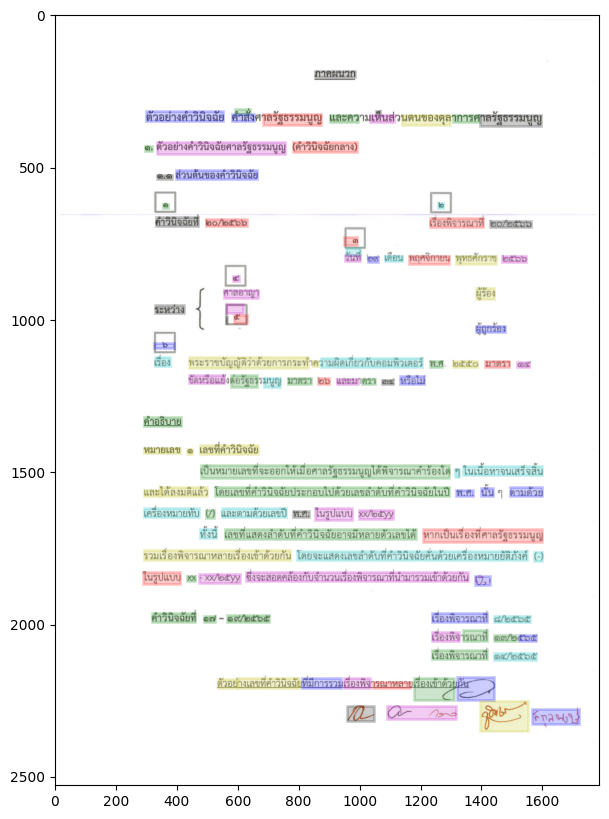

In [38]:
scale = fitz.Matrix(3,3)    
doc = ProcessedDoc('For wanut_Attach_TOR_1-11-33.pdf')
page_image = doc[0].get_opencv_img(scale=scale)
h,w,_ = page_image.shape
detect = detect_text(page_image)
detect = do_nms(detect)
plot_bounding_boxes(page_image, detect)


In [36]:
[box['bbox'][3]-box['bbox'][1] for box in detect]

[20,
 17,
 11,
 7,
 8,
 33,
 23,
 36,
 22,
 23,
 33,
 22,
 35,
 14,
 41,
 33,
 14,
 29,
 13,
 17,
 30,
 23,
 29,
 21,
 28,
 20,
 7,
 5,
 5,
 18,
 14,
 18,
 27,
 26,
 19,
 17,
 26,
 36,
 27,
 28,
 19,
 28,
 18,
 17,
 28,
 36,
 15,
 29,
 19,
 19,
 18,
 16,
 26,
 38,
 29,
 18,
 19,
 17,
 18,
 15,
 28,
 32,
 18,
 14,
 30,
 42,
 26,
 32,
 19,
 31,
 32,
 20,
 29,
 30,
 30,
 26,
 31,
 20,
 41,
 29,
 30,
 31,
 43,
 31,
 31,
 27,
 42,
 16,
 30,
 31,
 31,
 30,
 19,
 5,
 24,
 30,
 21,
 29,
 34,
 22,
 20,
 29,
 22,
 31,
 32,
 33,
 33,
 22,
 73,
 75,
 50,
 41,
 99,
 51]

In [1]:
import torch

In [3]:
from safetensors.torch import load_file
weights = load_file("/home/saeed/florence2-training/models/model.safetensors")

In [5]:
weights.keys()

dict_keys(['image_pos_embed.column_embeddings.weight', 'image_pos_embed.row_embeddings.weight', 'image_proj_norm.bias', 'image_proj_norm.weight', 'image_projection', 'language_model.final_logits_bias', 'language_model.lm_head.weight', 'language_model.model.decoder.embed_positions.weight', 'language_model.model.decoder.layernorm_embedding.bias', 'language_model.model.decoder.layernorm_embedding.weight', 'language_model.model.decoder.layers.0.encoder_attn.k_proj.bias', 'language_model.model.decoder.layers.0.encoder_attn.k_proj.weight', 'language_model.model.decoder.layers.0.encoder_attn.out_proj.bias', 'language_model.model.decoder.layers.0.encoder_attn.out_proj.weight', 'language_model.model.decoder.layers.0.encoder_attn.q_proj.bias', 'language_model.model.decoder.layers.0.encoder_attn.q_proj.weight', 'language_model.model.decoder.layers.0.encoder_attn.v_proj.bias', 'language_model.model.decoder.layers.0.encoder_attn.v_proj.weight', 'language_model.model.decoder.layers.0.encoder_attn_la

In [1]:
from transformers import (
    EarlyStoppingCallback,
    Trainer,
    TrainingArguments,
)

/home/dll/anaconda3/envs/thesis/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.
0it [00:00, ?it/s]
